# Dataset Presentation

The dataset we will use for this exercise is the "Web Traffic Anomaly Detection" dataset. This dataset, collected through AWS CloudWatch, provides web traffic records aimed at identifying suspicious activities and potential attack attempts. You can find the dataset at the provided directory: `../datasets/CloudWatch_Traffic_Web_Attack.csv`.

**Features of the Dataset:**

1. **bytes_in:** The amount of data (in bytes) received by the server during the connection.
2. **bytes_out:** The amount of data (in bytes) sent from the server during the connection.
3. **creation_time:** The timestamp when the traffic record was created.
4. **end_time:** The timestamp when the connection ended.
5. **src_ip:** The IP address of the source sending traffic to the server.
6. **src_ip_country_code:** The country code of the source IP address.
7. **protocol:** The protocol used for the connection (e.g., HTTP, HTTPS).
8. **response.code:** The HTTP response code sent by the server.
9. **dst_port:** The destination port on the server.
10. **dst_ip:** The IP address of the server receiving the traffic.
11. **rule_names:** The names of the detection rules that flagged the traffic as suspicious.
12. **observation_name:** Observations related to the detected traffic.
13. **source.meta:** Metadata associated with the source of the traffic.
14. **source.name:** The name of the traffic source.
15. **time:** The timestamp of when the event was detected.
16. **detection_types:** The types of detection mechanisms applied to identify suspicious traffic.

#### Problem Definition

**Objective:**
We aim to identify and analyze anomalous web traffic patterns to enhance threat detection capabilities. The goal is to develop models that can detect unusual behaviors in web traffic (`rule_names` and `detection_types`) using various features such as `bytes_in`, `bytes_out`, `protocol`, `src_ip`, `src_ip_country_code`, `dst_port`, and other relevant metadata.

**Why This Problem is Interesting:**
Detecting anomalous web traffic is critical for several reasons:
- **For Security Teams:** Enhances the ability to respond to and mitigate cyber threats in real time, reducing the risk of data breaches and service disruptions.
- **For System Administrators:** Helps in maintaining the integrity and performance of web servers by identifying and managing potential attack vectors.
- **For Researchers and Developers:** Provides a practical dataset to develop and test new anomaly detection algorithms, contributing to advancements in cybersecurity.

In an industry where cybersecurity is increasingly vital, leveraging such a dataset can significantly improve an organization's defense mechanisms against evolving cyber threats.

# Workflow

Ah the scroing metric we choose to use the Silhouette. The silhouette score is a good fit for unsupervised clustering because it provides a measure of how similar each point is to its own cluster compared to other clusters, thus evaluating the compactness and separation of clusters.

1. **Initial KMeans Clustering without PCA**:
   - **Preprocessing**: StandardScaler for numerical features and OneHotEncoder for categorical features.
   - **Clustering**: Applied KMeans directly to preprocessed data.
   - **Evaluation**: Calculated silhouette score to assess clustering quality.

2. **KMeans Clustering with PCA**:
   - **Preprocessing**: StandardScaler for numerical features and OneHotEncoder for categorical features.
   - **Dimensionality Reduction**: Applied PCA to reduce feature dimensions to 2.
   - **Clustering**: Applied KMeans on PCA-transformed data.
   - **Evaluation**: Calculated silhouette score to evaluate clustering performance in reduced dimensionality.

3. **GridSearchCV for Hyperparameter Tuning**:
   - **Objective**: Used GridSearchCV to optimize KMeans parameters (number of clusters and other hyperparameters).
   - **Scoring**: Utilized silhouette score as the scoring metric for grid search.
   - **Parameter Grid**: Explored various configurations to maximize silhouette score.

4. **Exploration of Different Distance Metrics**:
   - **Objective**: Explored alternative distance metrics (e.g., Euclidean, Manhattan, Minkowski, Hamming) in GridSearchCV.
   - **Evaluation**: Aimed to identify the best-performing distance metric based on silhouette score.

5. **Final Model Selection and Analysis**:
   - **Selection**: Identified the best-performing model from the grid search based on silhouette score.
   - **Analysis**: Further analyzed the selected model:
     - Plotted correlation between clusters and features.
     - Visualized clusters using dendrogram (hierarchical clustering) and scatter plots (PCA-transformed data).

This workflow encapsulates the iterative process of exploring, refining, and analyzing clustering models using KMeans, PCA for dimensionality reduction, and grid search for hyperparameter optimization, all centered around maximizing silhouette scores to ensure robust clustering performance.

# Imports

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import GridSearchCV
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

# Data Import and Visualization

In [2]:
# Load the dataset
data = pd.read_csv('../datasets/CloudWatch_Traffic_Web_Attack.csv')

# Data exploration
print(data.head())
print(data.info())
print(data.describe())
print(data.columns)

   bytes_in  bytes_out         creation_time              end_time  \
0      5602      12990  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
1     30912      18186  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
2     28506      13468  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
3     30546      14278  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
4      6526      13892  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

         dst_ip              rule_names                      observation_name  \
0  10.138.69.97  Suspicious Web Traffic  

In [3]:
# Describe the numerical columns
print(data.describe())

           bytes_in     bytes_out  response.code  dst_port
count  2.820000e+02  2.820000e+02          282.0     282.0
mean   1.199390e+06  8.455429e+04          200.0     443.0
std    4.149312e+06  2.549279e+05            0.0       0.0
min    4.000000e+01  4.400000e+01          200.0     443.0
25%    5.381500e+03  1.114200e+04          200.0     443.0
50%    1.318200e+04  1.379950e+04          200.0     443.0
75%    3.083300e+04  2.627950e+04          200.0     443.0
max    2.520779e+07  1.561220e+06          200.0     443.0


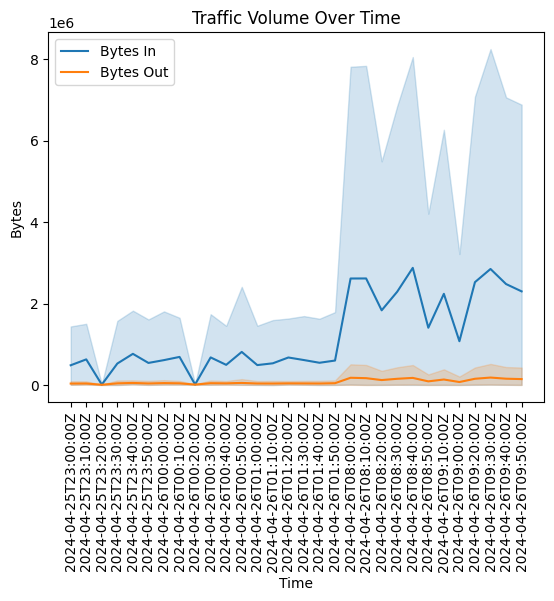

In [4]:
# Plotting bytes_in and bytes_out over time
sns.lineplot(data=data, x='creation_time', y='bytes_in', label='Bytes In')
sns.lineplot(data=data, x='creation_time', y='bytes_out', label='Bytes Out')
plt.title('Traffic Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.xticks(rotation=90)
plt.legend()
plt.show()


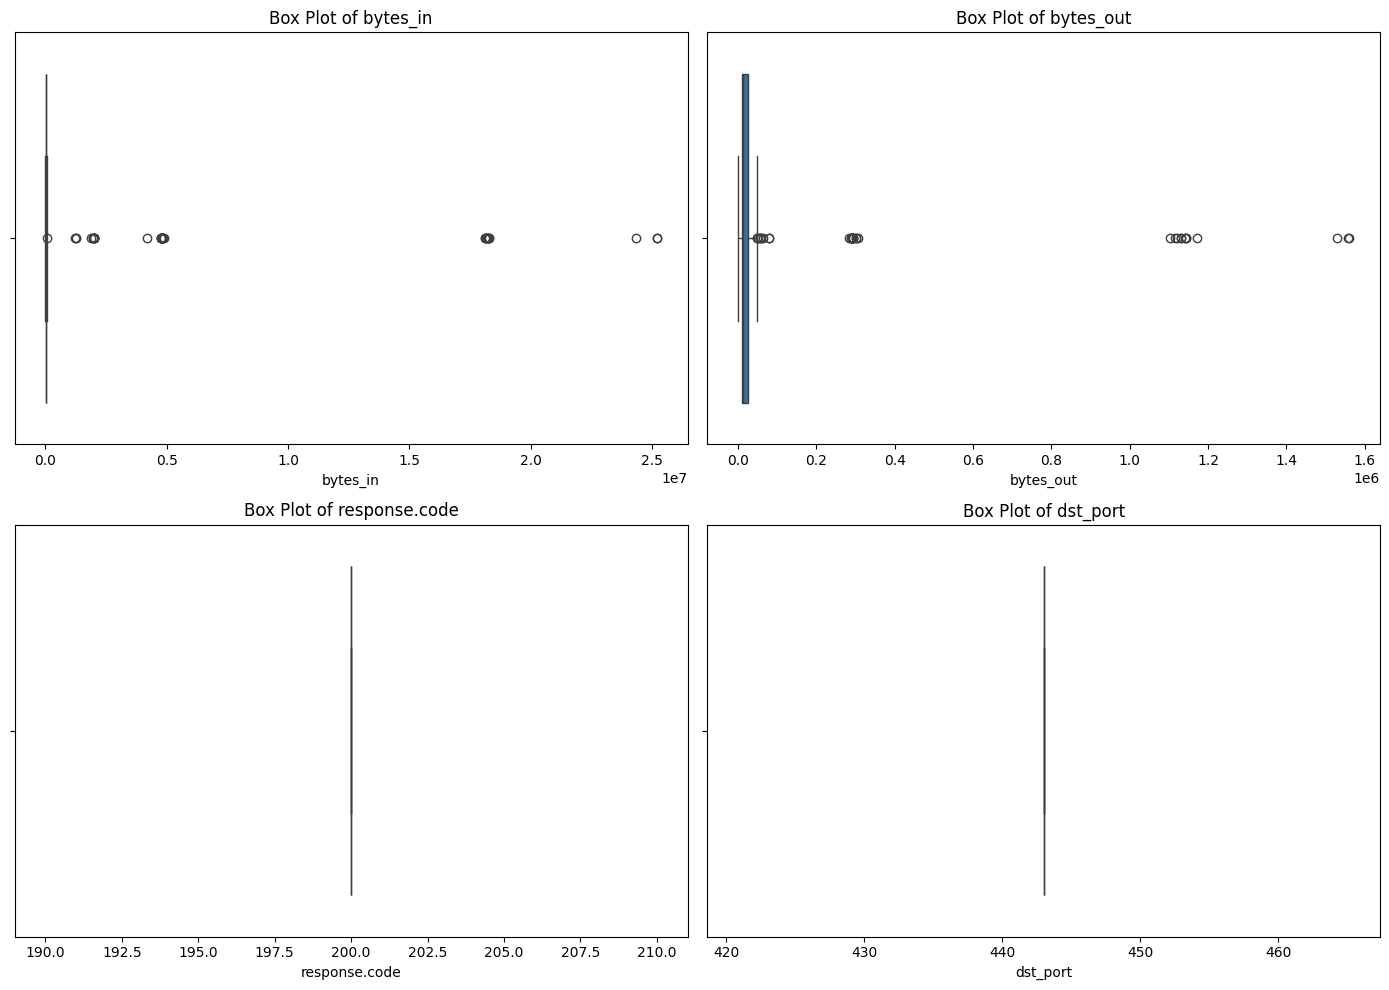

In [5]:
# Plot distributions of numerical features
numerical_features = ['bytes_in', 'bytes_out', 'response.code', 'dst_port']

# Box plots to identify outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')
    axes[i].set_xlabel(feature)

plt.tight_layout()
plt.show()

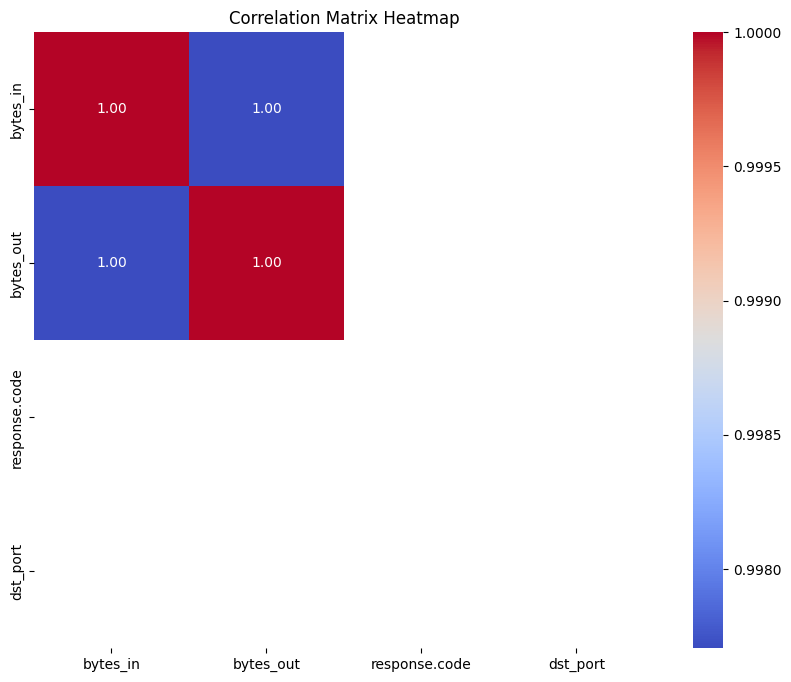

In [6]:
correlation_matrix_numeric = data[numerical_features].corr()

# Heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

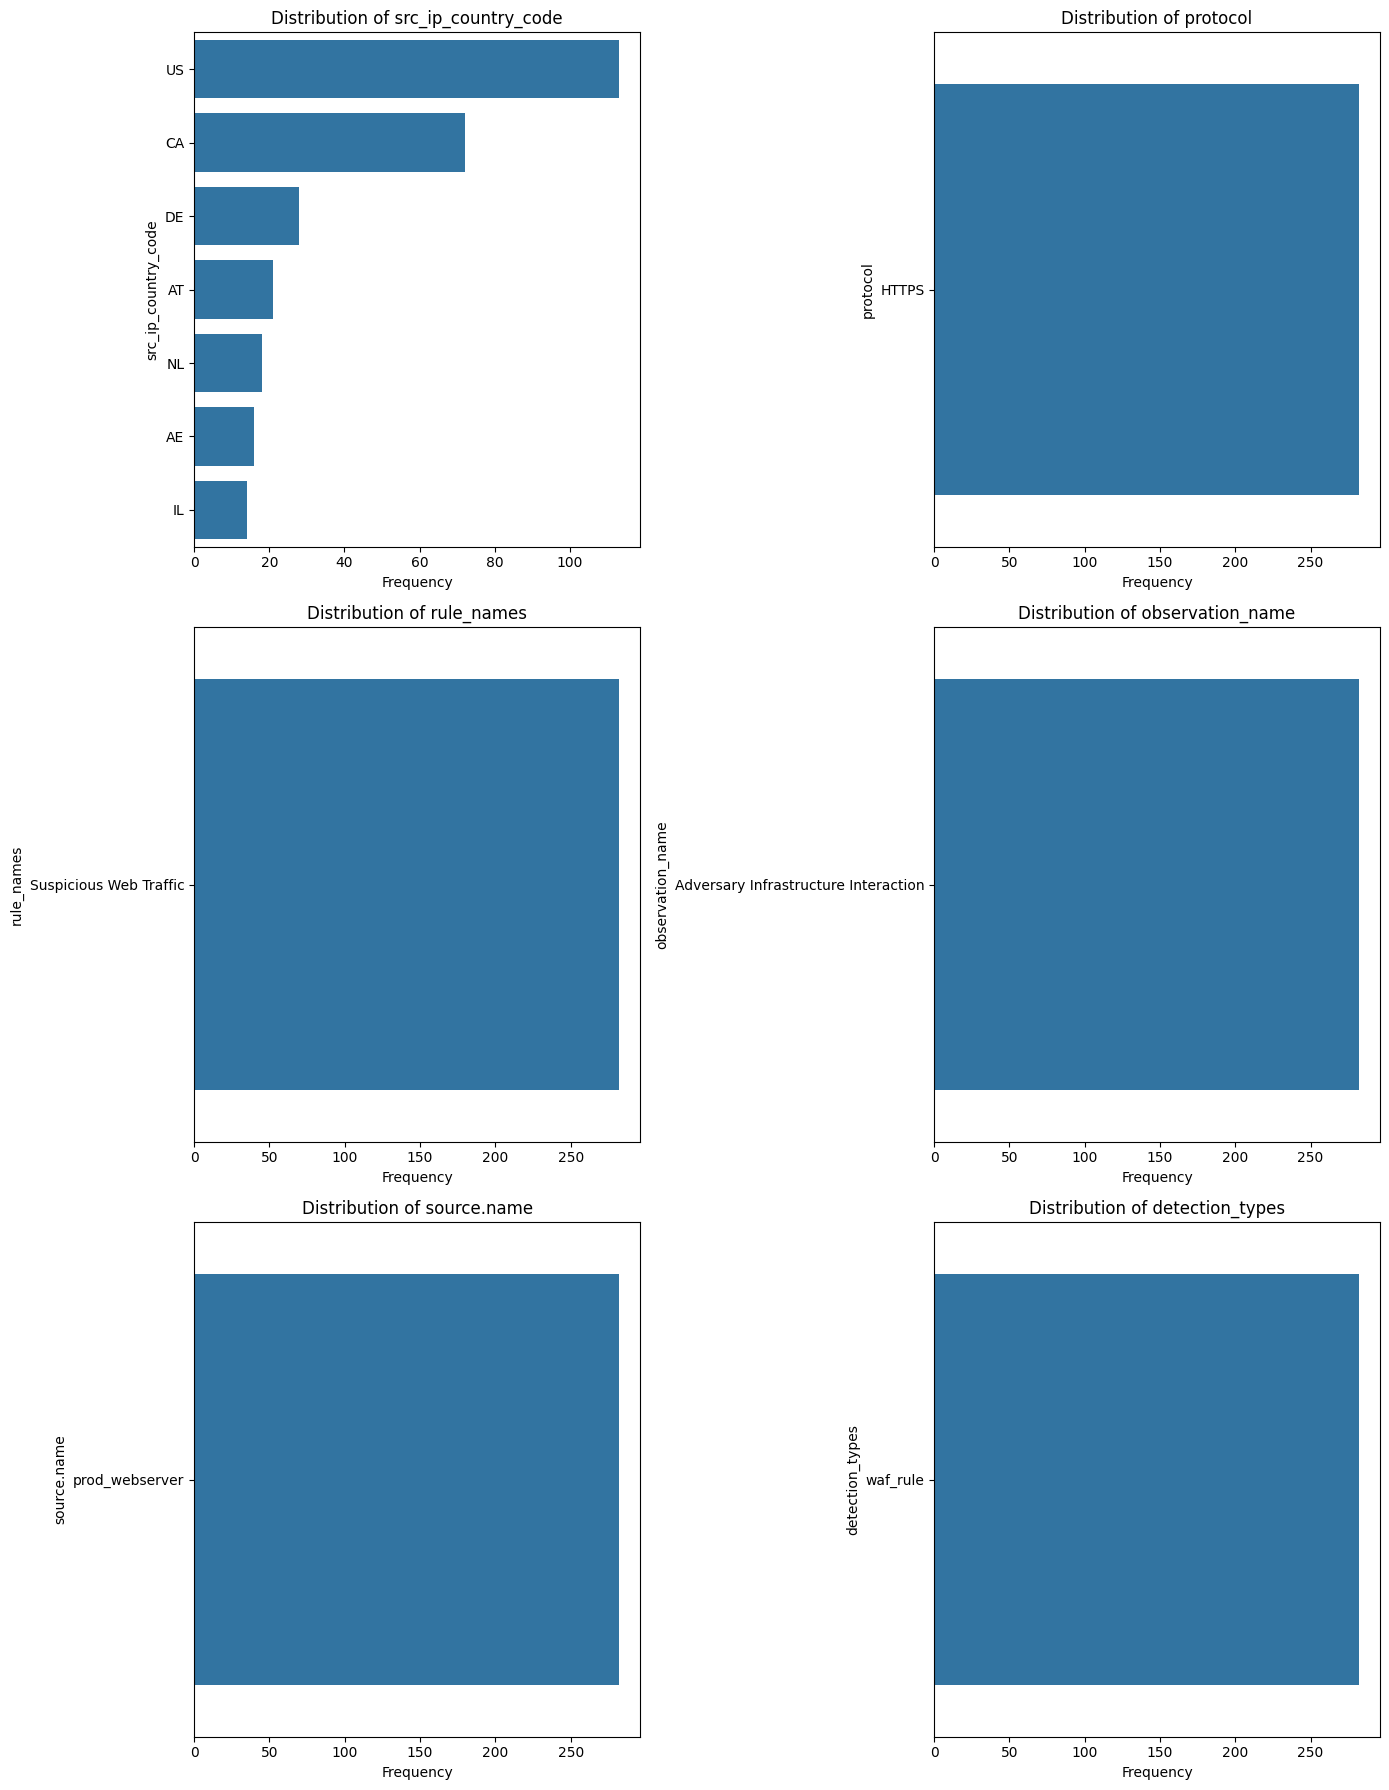

In [7]:
# Categorical features
categorical_features = ['src_ip_country_code', 'protocol', 'rule_names', 'observation_name', 'source.name', 'detection_types']

fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sns.countplot(y=data[feature], ax=axes[i], order=data[feature].value_counts().index)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

# Preprocessing

In [8]:
# Drop non-relevant columns for unsupervised learning
unsupervised_data = data.drop(columns=['creation_time', 'end_time', 'time', 'src_ip', 'dst_ip', 'rule_names', 'observation_name', 'source.meta', 'source.name'])

# Define numerical and categorical features
numerical_features = ['bytes_in', 'bytes_out', 'response.code', 'dst_port']
categorical_features = ['src_ip_country_code', 'protocol', 'detection_types']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Comparison of Pipelines

## KMeans without PCA

In [9]:
# KMeans clustering pipeline without PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

In [10]:
# Fit the pipeline to the data
pipeline.fit(unsupervised_data)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bytes_in', 'bytes_out',
                                                   'response.code',
                                                   'dst_port']),
                                                 ('cat', OneHotEncoder(),
                                                  ['src_ip_country_code',
                                                   'protocol',
                                                   'detection_types'])])),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [11]:
# Get preprocessed data for silhouette score
preprocessed_data = pipeline.named_steps['preprocessor'].transform(unsupervised_data)

# Get cluster labels and add to a copy of the original data
data_copy = data.copy()
data_copy['cluster'] = pipeline.named_steps['kmeans'].labels_

# Evaluate the clustering
silhouette_avg = silhouette_score(preprocessed_data, data_copy['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.4645421613331029


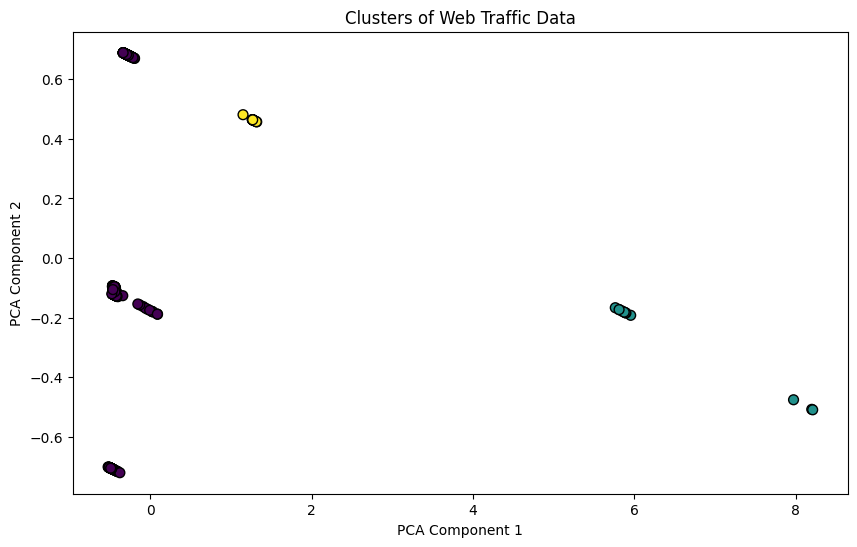

In [12]:
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(preprocessed_data)

plt.figure(figsize=(10, 6))
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=data_copy['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Clusters of Web Traffic Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## KMeans With PCA

In [13]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)

# KMeans clustering pipeline with PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

In [14]:
# Fit the pipeline to the data
pipeline.fit(unsupervised_data)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bytes_in', 'bytes_out',
                                                   'response.code',
                                                   'dst_port']),
                                                 ('cat', OneHotEncoder(),
                                                  ['src_ip_country_code',
                                                   'protocol',
                                                   'detection_types'])])),
                ('pca', PCA(n_components=2)),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [15]:
# Get preprocessed data for silhouette score
preprocessed_data = pipeline.named_steps['preprocessor'].transform(unsupervised_data)
pca_transformed_data = pipeline.named_steps['pca'].transform(preprocessed_data)

# Get cluster labels and add to a copy of the original data
data_copy = data.copy()
data_copy['cluster'] = pipeline.named_steps['kmeans'].labels_

# Evaluate the clustering
silhouette_avg = silhouette_score(pca_transformed_data, data_copy['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.518343718639374


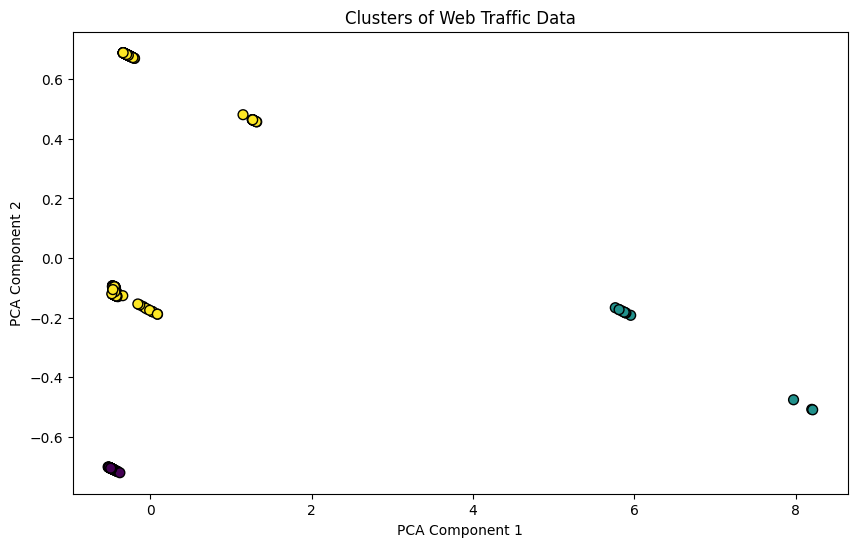

In [16]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_transformed_data[:, 0], pca_transformed_data[:, 1], c=data_copy['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Clusters of Web Traffic Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## GridSearch with Silouhette

In [17]:
# Custom scorer for silhouette score
def silhouette_scorer(estimator, X):
    preprocessed_data = estimator.named_steps['preprocessor'].transform(X)
    cluster_labels = estimator.named_steps['kmeans'].fit_predict(preprocessed_data)
    return silhouette_score(preprocessed_data, cluster_labels)

In [18]:
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA()),
    ('kmeans', KMeans(random_state=42))
])

# Parameter grid for grid search
param_grid = {
    'pca__n_components': [2, 3, 4, 5],
    'kmeans__n_clusters': [2, 3, 4, 5],
    'kmeans__algorithm': ['lloyd', 'elkan']
}

In [19]:
# Grid search for KMeans clustering
grid_search = GridSearchCV(pipeline, param_grid, scoring=silhouette_scorer, cv=5)

# Fit the grid search
grid_search.fit(unsupervised_data)

# Best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Silhouette Score: {grid_search.best_score_}")

Best Parameters: {'kmeans__algorithm': 'lloyd', 'kmeans__n_clusters': 5, 'pca__n_components': 2}
Best Silhouette Score: 0.7127039289020634


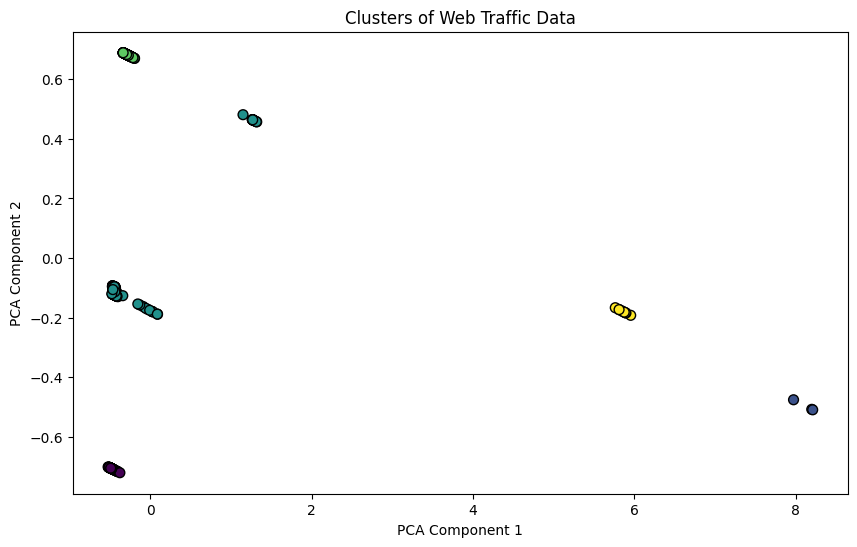

In [20]:
# Get the best estimator
best_estimator = grid_search.best_estimator_

# Get preprocessed data for visualization
preprocessed_data = best_estimator.named_steps['preprocessor'].transform(unsupervised_data)
pca_transformed_data = best_estimator.named_steps['pca'].transform(preprocessed_data)

# Add cluster labels to a copy of the original data
data_copy = data.copy()
data_copy['cluster'] = best_estimator.named_steps['kmeans'].labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_transformed_data[:, 0], pca_transformed_data[:, 1], c=data_copy['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Clusters of Web Traffic Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## GridSearch With different distances

In [21]:
# Custom scorer for silhouette score
def silhouette_scorer(estimator, X):
    preprocessed_data = estimator.named_steps['preprocessor'].transform(X)
    cluster_labels = estimator.named_steps['kmedoids'].fit_predict(preprocessed_data)
    return silhouette_score(preprocessed_data, cluster_labels)

In [22]:
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA()),
    ('kmedoids', KMedoids(random_state=42))
])

# Parameter grid for grid search
param_grid = {
    'pca__n_components': [2, 3, 4, 5],
    'kmedoids__n_clusters': [2, 3, 4, 5],
    'kmedoids__metric': ['euclidean', 'manhattan', 'minkowski', 'hamming']
}

In [23]:
# Suppress specific warnings related to empty clusters
warnings.filterwarnings("ignore", message="Cluster.*is empty!")

# Grid search for KMedoids clustering
grid_search = GridSearchCV(pipeline, param_grid, scoring=silhouette_scorer, cv=5)

# Fit the grid search
grid_search.fit(unsupervised_data)

# Best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Silhouette Score: {grid_search.best_score_}")

Best Parameters: {'kmedoids__metric': 'manhattan', 'kmedoids__n_clusters': 2, 'pca__n_components': 2}
Best Silhouette Score: 0.4510959194115845


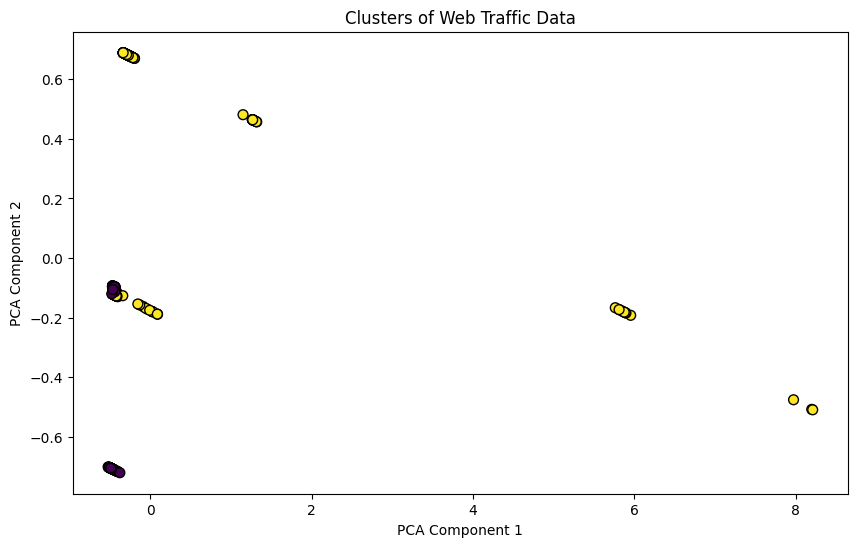

In [24]:
# Get the best estimator
best_estimator = grid_search.best_estimator_

# Get preprocessed data for visualization
preprocessed_data = best_estimator.named_steps['preprocessor'].transform(unsupervised_data)
pca_transformed_data = best_estimator.named_steps['pca'].transform(preprocessed_data)

# Add cluster labels to a copy of the original data
data_copy = data.copy()
data_copy['cluster'] = best_estimator.named_steps['kmedoids'].fit_predict(preprocessed_data)

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_transformed_data[:, 0], pca_transformed_data[:, 1], c=data_copy['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Clusters of Web Traffic Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Analysis with the best Estimators

In [25]:
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),
    ('kmeans', KMeans(random_state=42, algorithm='lloyd', n_clusters=5))
])

In [26]:
# Fit the grid search
pipeline.fit(unsupervised_data)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bytes_in', 'bytes_out',
                                                   'response.code',
                                                   'dst_port']),
                                                 ('cat', OneHotEncoder(),
                                                  ['src_ip_country_code',
                                                   'protocol',
                                                   'detection_types'])])),
                ('pca', PCA(n_components=2)),
                ('kmeans', KMeans(n_clusters=5, random_state=42))])

In [27]:
# Get preprocessed data for silhouette score
preprocessed_data = pipeline.named_steps['preprocessor'].transform(unsupervised_data)
pca_transformed_data = pipeline.named_steps['pca'].transform(preprocessed_data)

# Get cluster labels and add to a copy of the original data
data_copy = data.copy()
data_copy['cluster'] = pipeline.named_steps['kmeans'].labels_

# Evaluate the clustering
silhouette_avg = silhouette_score(pca_transformed_data, data_copy['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.7275617913358658


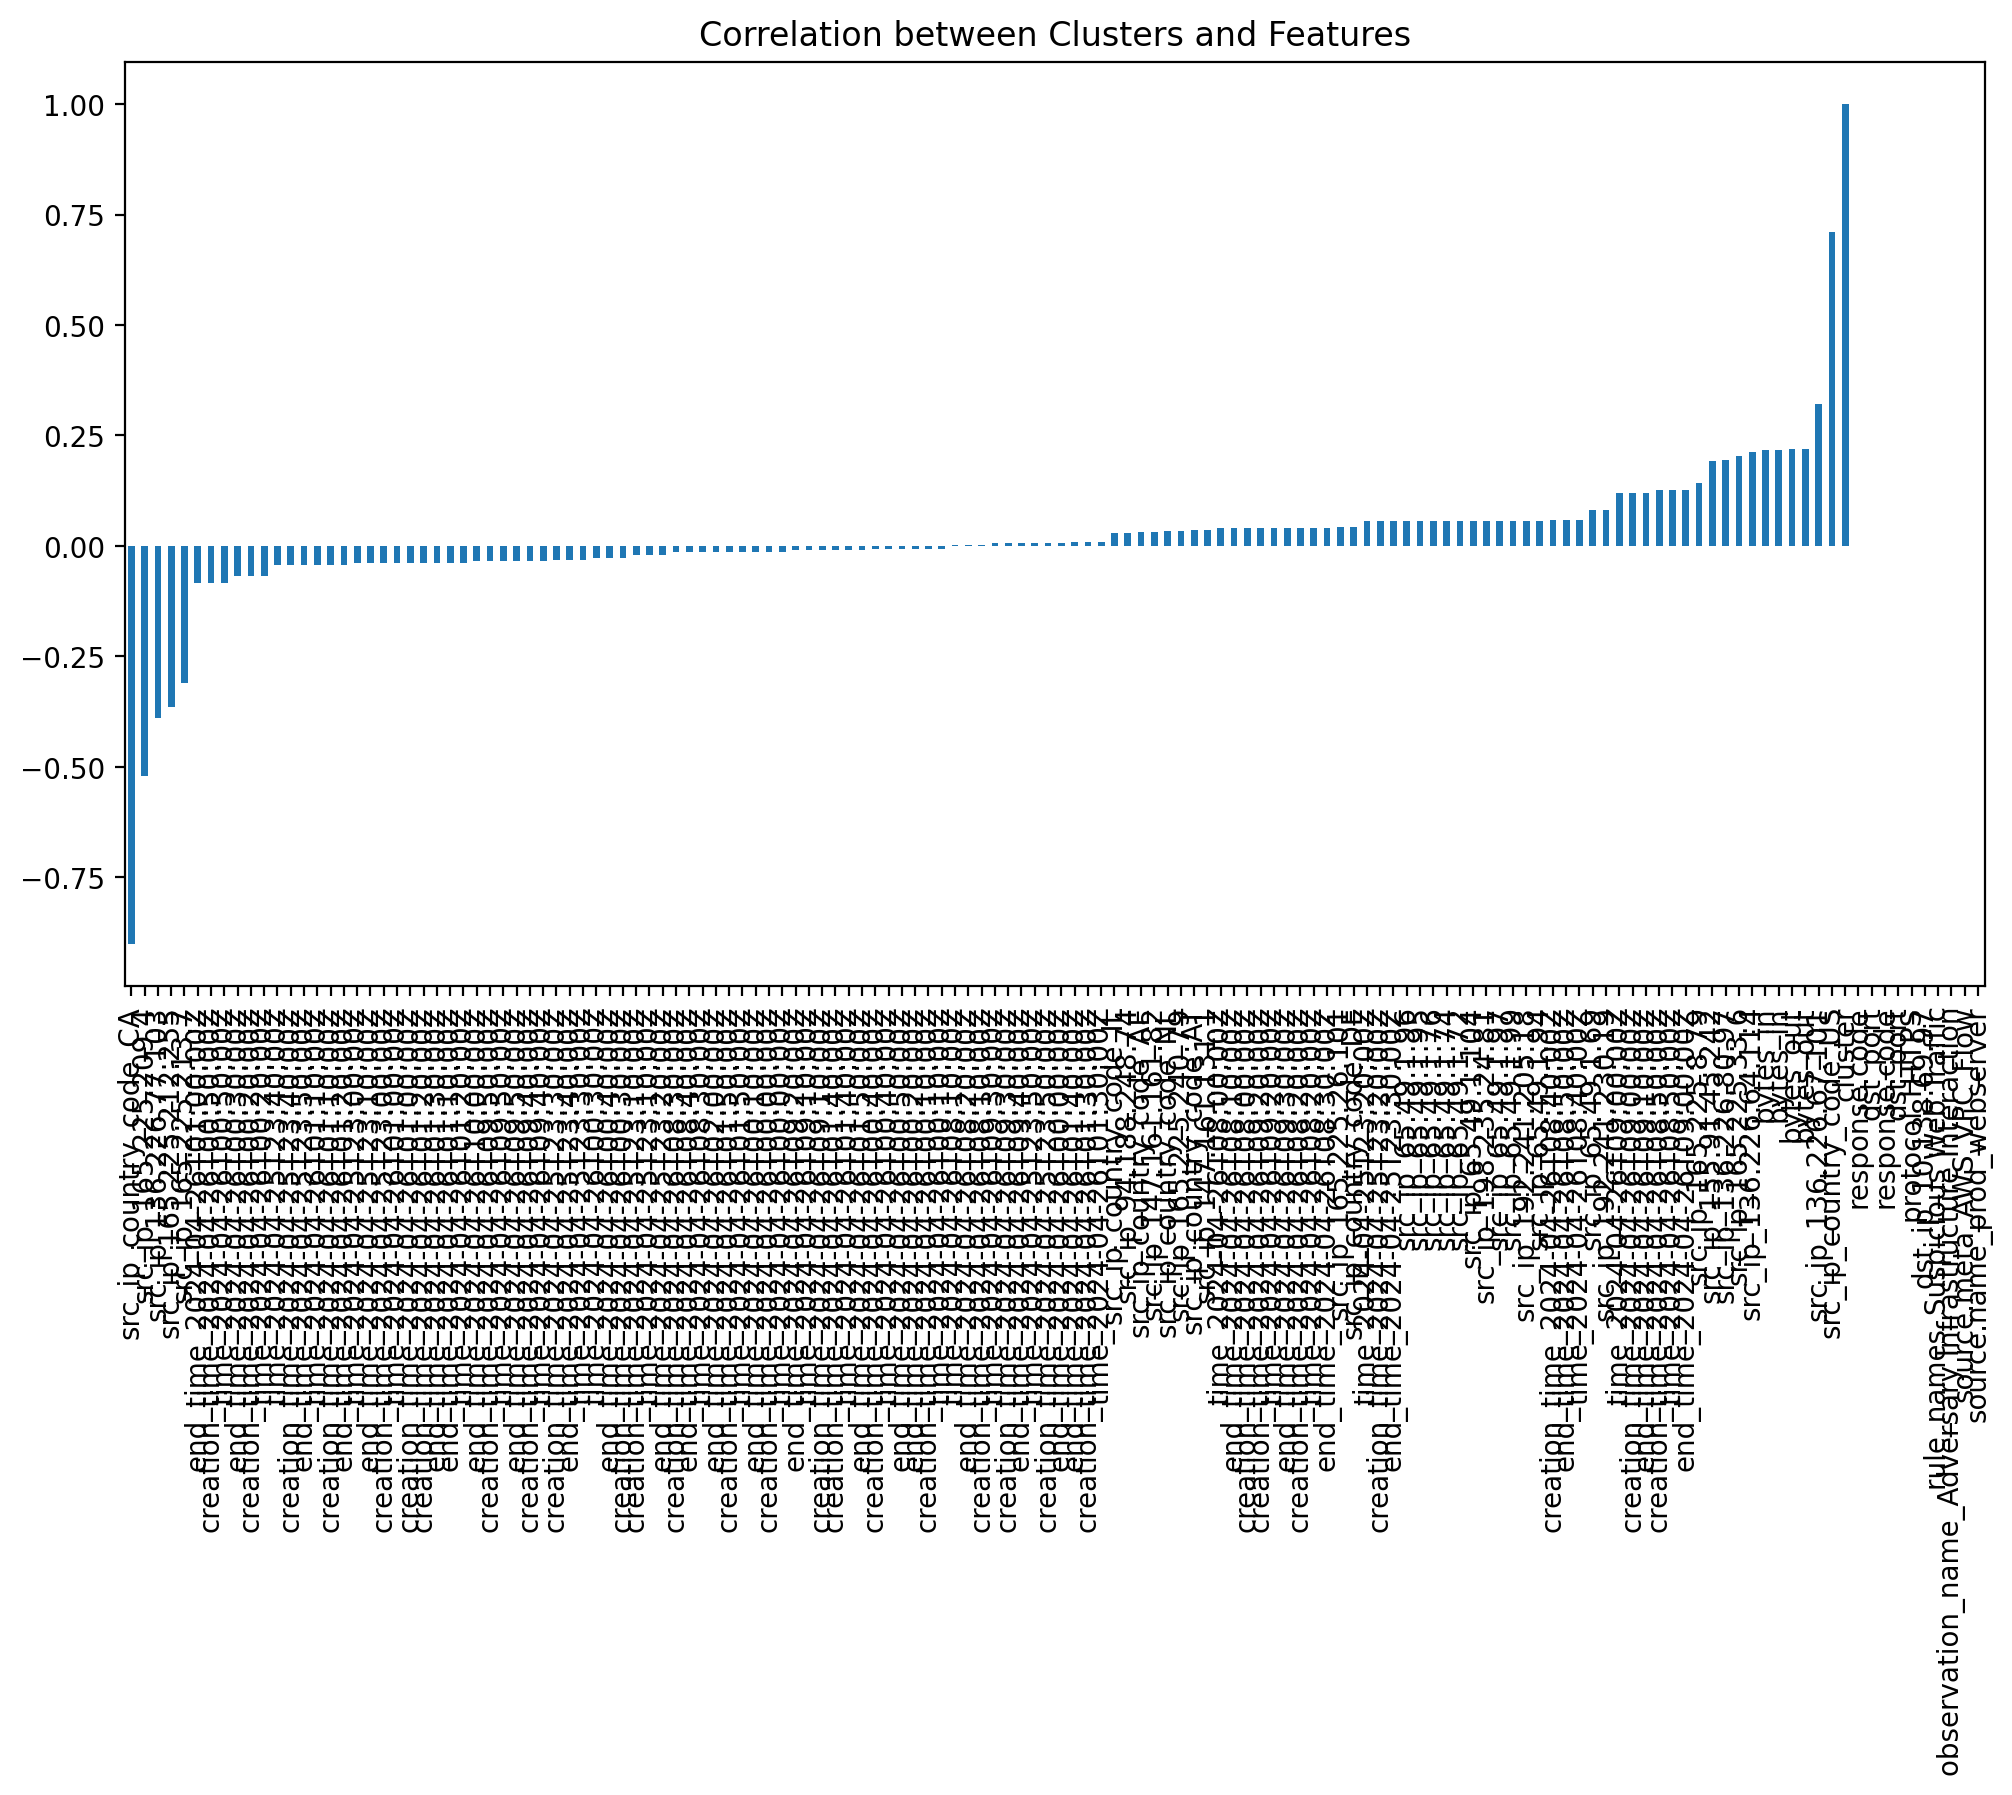

In [28]:
# Dummy encode categorical features
dummy_encoded = pd.get_dummies(data_copy)

# Concatenate dummy encoded features with numeric features
data_for_corr = pd.concat([data_copy[numerical_features], dummy_encoded], axis=1)

# Calculate correlation with clusters
plt.figure(figsize=(12, 6), dpi=200)
data_for_corr.corr()['cluster'].iloc[:-1].sort_values().plot(kind='bar')
plt.title('Correlation between Clusters and Features')
plt.show()

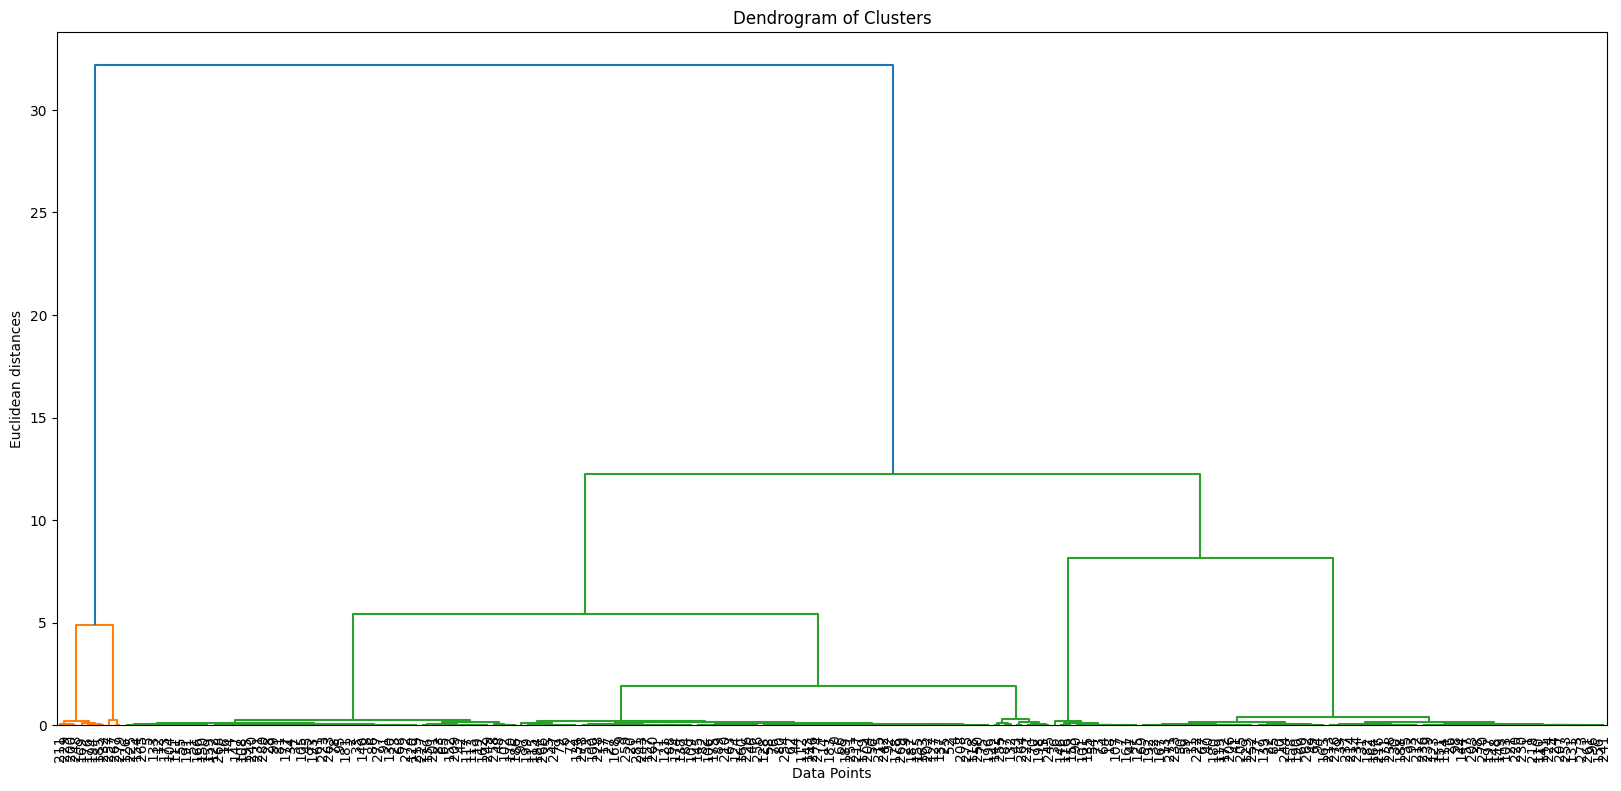

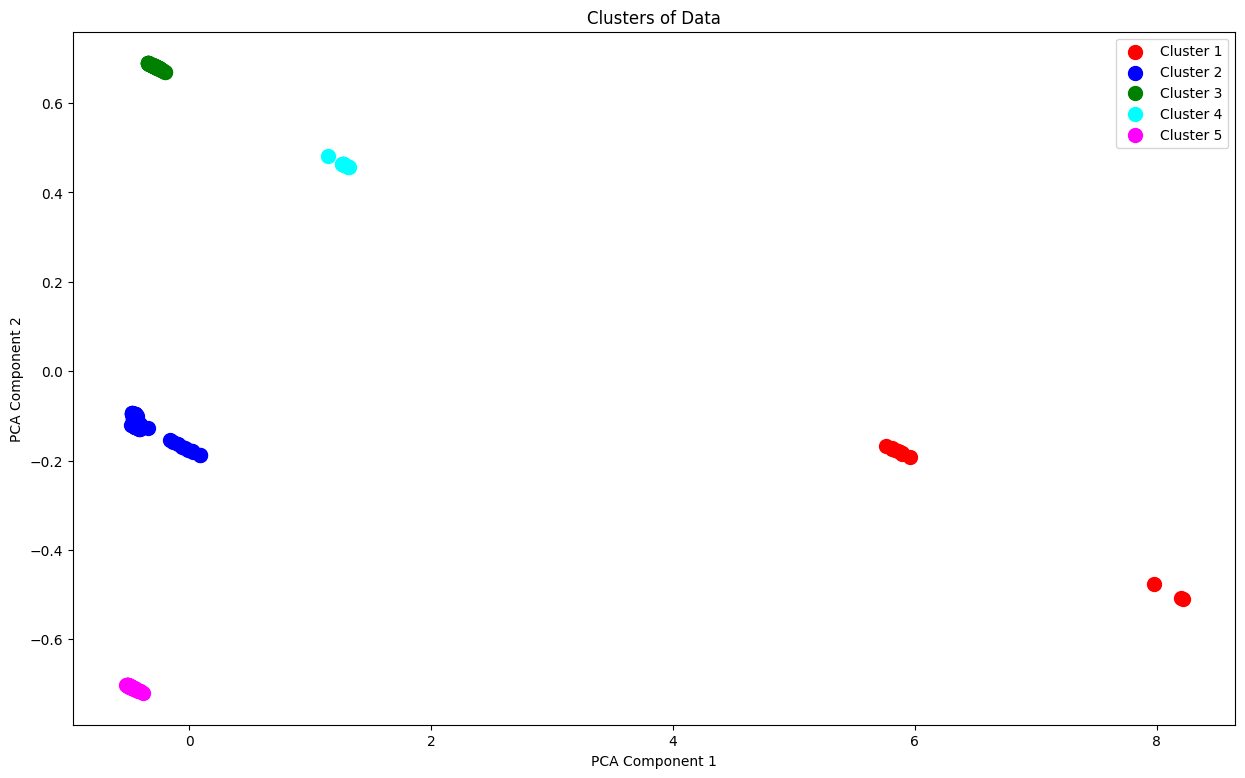

In [29]:
# Fit hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=5, linkage='ward')  # Remove affinity parameter
y_hierarchical = hierarchical.fit_predict(pca_transformed_data)  # Use pca_transformed_data from your pipeline

# Plot dendrogram
plt.figure(figsize=(20, 9))
dendrogram = hierarchy.dendrogram(hierarchy.linkage(pca_transformed_data, method='ward'), leaf_font_size=10)
plt.title('Dendrogram of Clusters')
plt.xlabel('Data Points')
plt.ylabel('Euclidean distances')
plt.grid(False)
plt.xticks(rotation=90)
plt.show()

# Plot clusters
plt.figure(figsize=(15, 9))
colors = ['red', 'blue', 'green', 'cyan', 'magenta']
for i in range(5):
    plt.scatter(pca_transformed_data[y_hierarchical == i, 0], pca_transformed_data[y_hierarchical == i, 1], 
                s=100, c=colors[i], label=f'Cluster {i+1}')
plt.title('Clusters of Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(False)
plt.legend()
plt.show()

# Summary of Results

Our iterative approach to clustering, starting from basic KMeans to more advanced techniques involving PCA and grid search optimization, demonstrated significant improvements in cluster quality. The highest silhouette score of 0.71 achieved through grid search underscores the importance of hyperparameter tuning in clustering tasks. The visualizations and correlation analysis further validated the distinctiveness and interpretability of the resulting clusters. However, the slight drop in performance when exploring different distance metrics highlights that the choice of distance measure is critical and dataset-specific.

**Cluster Quality:**
The clustering models, particularly the one optimized through grid search, showed significant improvements in silhouette scores, indicating well-defined, cohesive clusters. This suggests that our approach effectively grouped the web traffic data into distinct clusters, which is a crucial step in identifying anomalous patterns.

**Feature Insights:**
The correlation analysis highlighted the most influential features for clustering, providing valuable insights into the data's structure. This is critical for understanding which attributes are most indicative of normal versus anomalous behavior in web traffic.

**Visual Confirmation:**
The dendrogram and cluster scatter plot provided visual confirmation of the effectiveness of our clustering approach. The clear separation of clusters in these plots suggests that our models can distinguish between different types of web traffic patterns.

### Conclusion

While our clustering approach showed significant improvements in terms of silhouette scores and visual cluster separation, it is only a part of the solution for anomaly detection in web traffic. The clustering models effectively group data into distinct patterns, which is a necessary step towards identifying anomalies. However, further steps are required to specifically label and understand the nature of these anomalies in the context of cyber threats.

In summary, our work has laid a solid foundation for enhancing threat detection capabilities by effectively clustering web traffic data. The insights gained from this clustering can now be used to develop more targeted anomaly detection models, which can directly address the problem of identifying and mitigating anomalous web traffic patterns. This iterative process underscores the importance of combining multiple analytical techniques to solve complex cybersecurity problems comprehensively.